In [560]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate

from statsmodels.tsa.stattools import adfuller # For DF test
from statsmodels.tsa.vector_ar.var_model import VAR # to build the model
import statsmodels.api as sm #decompose data
from statsmodels.tsa.stattools import grangercausalitytests #For checking the casuality investigation


from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf
from numpy import array , hstack
from pandas import concat
from pandas import DataFrame

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
'''The dataset has 123 rows and 8 columns and the definition of columns are shown below.

rgnp : Real GNP.
pgnp : Potential real GNP.
ulc : Unit labor cost.
gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
gdf : Fixed weight GNP deflator.
gdfim : Fixed weight import deflator.
gdfcf : Fixed weight deflator for food in personal consumption expenditure.
gdfce : Fixed weight deflator for energy in personal consumption expenditure.

For this problem I have applied the VAR and RNN(LSTM). '''

In [ ]:
'''For this script I have used a multivariate time series dataset used in Yash P Mehra’s 1994 article. This dataset consisit of 
8 columns and the values in each column are float elements. The goal of thie problem is to forecast the value of each column.
My approach is based on forecasting using VAR model and includes the following steps:

1. Loading data and some data exploration such as finding the number of data, datatypes, data describtion,...

2. data visualization: In this step we can see a plot for each column in dataset.

3. In the following and before implementing model we should check the seasonality in dataset and remove them. This step can be 
   done by seasonal_decompose() function.
   
4. Causality Investigation: In this step using granger test we can check the causality investication which means that if a variable
   come before the other variable make a useful result. On the other word if we will test that wheather VAR or VARIMA is suitable for
   data set or not. This test will be done by grangercausalitytests() function from statsmodels library.
   
5. checking the stationary: In this step we will check the stationary. A data is called stationary if its the mean and variance
   are constant values and its autocovariance is not dpend on time. Most of time series models neeed stationary data. To check the
   statinary we can use visualization or Df test. For visualization we can plot the mean and variance of data and check that if 
   are constant values. 
   Another way is Df test. In this test we will check the p-value for data. If p-value is less than 0.05 then we will say that data
   is stationary and otherwise data is not stationary.
   
   
6. Conver data into stationary format: There are two common method to convert data into stationary format:differencing and 
   transformation method. In this problem I have used differencing. Using the p-value we can find the order of differencing.
   
7. IN this step dataset will be divided into training and test sets. I have applied the test set to evaluate the model.

8. I have implemented the VAR(vector auto regression) model on the stationary data.

9. before fitting the model I have defined the value of p. Indeed we should define the value of p for AR part of model. For this
   part I have used the AIC value and p is the order that makes the least AIC and then we can fit the model using p.

10. Now our model is ready for forecasting on data. In order to forecast, the VAR model expects up to the lag order number of 
    observations from the past data. We can find the lag order by model.k_ar. After convert data into lag data we can use the
    model on the test set to forecast data.
    
11. In this step I have innverted forecasted data into original format by dedifferencing data. Indeed Invert the transformation 
    to get the real forecast.
    
12. Finally we can plot the forecasted data vs real values to get a vision about forecasting model.

13. In the final step we can evaluate the forecasts.

14. I have implemented LSTM model for this dataset. Before building the model we  need some preprocessing step
   '''

In [413]:
df=pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv',parse_dates=['date'], index_col='date')

In [414]:
df.head()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8


In [415]:
df.dtypes
#All values are float elements

rgnp     float64
pgnp     float64
ulc      float64
gdfco    float64
gdf      float64
gdfim    float64
gdfcf    float64
gdfce    float64
dtype: object

In [416]:
len(df)
#There are 123 row of data

123

In [417]:
df.info()
#There is no missed value

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 1959-01-01 to 1989-07-01
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rgnp    123 non-null    float64
 1   pgnp    123 non-null    float64
 2   ulc     123 non-null    float64
 3   gdfco   123 non-null    float64
 4   gdf     123 non-null    float64
 5   gdfim   123 non-null    float64
 6   gdfcf   123 non-null    float64
 7   gdfce   123 non-null    float64
dtypes: float64(8)
memory usage: 8.6 KB


'Visualize the data in the figure below and through our observation, all 8 variables has no obvious seasonality and each \ncurve slopes upward. Hence, in the following analysis, we will not consider the seasonality in the modeling.'

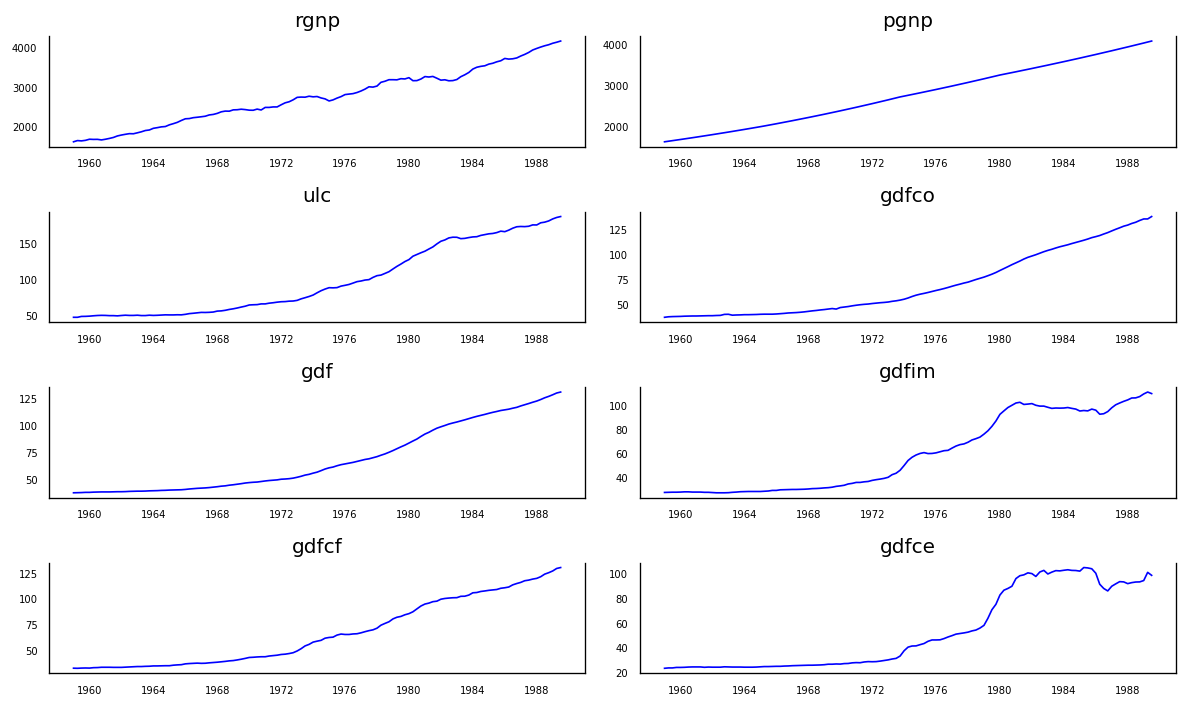

In [418]:
#Visualizing the time seies data for each column in df

fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout(); 

'''Visualize the data in the figure below and through our observation, all 8 variables has no obvious seasonality and each 
curve slopes upward. Hence, in the following analysis, we will not consider the seasonality in the modeling.'''

In [ ]:
''' Model Building
The data is ready, let’s start the trip of MTS modeling! We will involve the steps below:

 Causality investigation.
 Test for stationary.
 Model Building.
 Test for residuals (errors).'''

In [419]:
'''Causality Investigation
First, we use Granger Causality Test to investigate causality of data. Granger causality is a way to investigate the causality
between two variables in a time series which actually means if a particular variable comes before another in the time series.
In the MTS, we will test the causality of all combinations of pairs of variables'''



variables=['rgnp','pgnp','ulc','gdfco','gdf','gdfim','gdfcf','gdfce']


In [420]:
matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

matrix

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
rgnp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pgnp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ulc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gdfco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gdfim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gdfcf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gdfce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [421]:
matrix.columns

Index(['rgnp', 'pgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'], dtype='object')

In [422]:
maxlag=12

for col in matrix.columns:
    for row in matrix.index:
        test_result = grangercausalitytests(df[[row, col]], maxlag=maxlag, verbose=False)            
        p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(maxlag)]            
        min_p_value = np.min(p_values)
        matrix.loc[row, col] = min_p_value
matrix.columns = [var + '_x' for var in variables]
matrix.index = [var + '_y' for var in variables]
print(matrix)


'''From the result above, each column represents a predictor x of each variable and each row represents the response y and the
p-value of each pair of variables are shown in the matrix. Take the value 0.0212 in (row 1, column 4) as an example, it refers 
that gdfco_x is causal to rgnp_y. Whereas, the 0.0 in (row 4, column 1) also refers to gdfco_y is the cause of rgnp_x. As all 
values are all below 0.05 except the diagonal, we could reject that the null hypothesis and this dataset is a good candidate of 
VectorARIMA modeling.'''

         rgnp_x  pgnp_x   ulc_x  gdfco_x   gdf_x  gdfim_x  gdfcf_x  gdfce_x
rgnp_y   1.0000  0.0003  0.0001   0.0212  0.0014   0.0620   0.0001   0.0071
pgnp_y   0.0000  1.0000  0.0000   0.0000  0.0000   0.0000   0.0000   0.0000
ulc_y    0.0000  0.0000  1.0000   0.0002  0.0000   0.0000   0.0000   0.0041
gdfco_y  0.0000  0.0000  0.0000   1.0000  0.0000   0.0000   0.0000   0.0000
gdf_y    0.0000  0.0000  0.0000   0.0000  1.0000   0.0000   0.0000   0.0000
gdfim_y  0.0011  0.0067  0.0014   0.0083  0.0011   1.0000   0.0004   0.0000
gdfcf_y  0.0000  0.0000  0.0008   0.0008  0.0000   0.0038   1.0000   0.0009
gdfce_y  0.0025  0.0485  0.0000   0.0002  0.0000   0.0000   0.0000   1.0000


'From the result above, each column represents a predictor x of each variable and each row represents the response y and the\np-value of each pair of variables are shown in the matrix. Take the value 0.0212 in (row 1, column 4) as an example, it refers \nthat gdfco_x is causal to rgnp_y. Whereas, the 0.0 in (row 4, column 1) also refers to gdfco_y is the cause of rgnp_x. As all \nvalues are all below 0.05 except the diagonal, we could reject that the null hypothesis and this dataset is a good candidate of \nVectorARIMA modeling.'

In [410]:
#Stationary Test

'''As VectorARIMA requires time series to be stationary, we will use one popular statistical test. There are two common methods
to test stationary. Visualization method and Df method'''

'As VectorARIMA requires time series to be stationary, we will use one popular statistical test. There are two common methods\nto test stationary. Visualization method and Df method'

In [311]:
'''Now we can check by DF method. If the value of p-value is less than 0.05 then dataset is stationary and otherwise dataset
is not stationary'''


def df_test(time_series,variables):
    for item in variables:
        result=adfuller(time_series[item])[1]
        if result<0.05:
            print(f" {item} : result = {result} => Stationary. ")
        else:
            print(f" {item} : result = {result} => Non-stationary.")
   
    


In [312]:

df_test(df,variables)

'''From the results below, we could see none of these varibles is stationary. Let us use the differencing method to make them 
stationary.'''

 rgnp : result = 0.9886037114305949 => Non-stationary.
 pgnp : result = 0.9964612064726065 => Non-stationary.
 ulc : result = 0.9970991728829679 => Non-stationary.
 gdfco : result = 0.9870138472785788 => Non-stationary.
 gdf : result = 0.9953249001658118 => Non-stationary.
 gdfim : result = 0.9386740229058368 => Non-stationary.
 gdfcf : result = 0.998051164027281 => Non-stationary.
 gdfce : result = 0.814401530750196 => Non-stationary.


'From the results below, we could see none of these varibles is stationary. Let us use the differencing method to make them \nstationary.'

In [423]:
'''We can use diff() function to make stationary dataset and drop non value form dataset. df1 shows the differenced dataset. '''

df1=df.diff().dropna()

In [424]:
df1

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-04-01,30.6,13.9,0.0,0.5,0.1,0.1,-0.1,0.3
1959-07-01,-7.5,14.0,1.2,0.2,0.1,0.1,0.2,0.0
1959-10-01,13.9,14.1,0.1,0.1,0.2,0.0,0.1,0.4
1960-01-01,28.2,14.3,0.3,0.1,0.0,0.1,-0.1,0.0
1960-04-01,-4.8,14.4,0.5,0.2,0.2,0.2,0.4,0.1
...,...,...,...,...,...,...,...,...
1988-07-01,32.0,23.8,0.9,1.2,1.6,0.1,2.5,0.5
1988-10-01,26.7,23.9,1.7,1.8,1.3,1.1,1.4,0.1
1989-01-01,37.4,24.1,2.8,1.5,1.5,2.2,1.7,1.1


In [426]:
df_test(df1,variables)
'''Now we can see that three variables have been converted into stationary data, but the rest of the data are still 
non-stationary. So we will use again the differ() function to get stationary data.'''

 rgnp : result = 2.9633019848468996e-06 => Stationary. 
 pgnp : result = 0.40101497676472125 => Non-stationary.
 ulc : result = 0.006235131830238156 => Stationary. 
 gdfco : result = 0.7178736959774967 => Non-stationary.
 gdf : result = 0.5823703618159312 => Non-stationary.
 gdfim : result = 0.000553653708669569 => Stationary. 
 gdfcf : result = 0.3687771997417834 => Non-stationary.
 gdfce : result = 0.2673198799246977 => Non-stationary.


'Now we can see that three variables have been converted into stationary data, but the rest of the data are still \nnon-stationary. So we will use again the differ() function to get stationary data.'

In [427]:
df2=df1.diff().dropna()

In [428]:
df2

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-07-01,-38.1,0.1,1.2,-3.000000e-01,0.0,0.0,0.3,-0.3
1959-10-01,21.4,0.1,-1.1,-1.000000e-01,0.1,-0.1,-0.1,0.4
1960-01-01,14.3,0.2,0.2,-7.105427e-15,-0.2,0.1,-0.2,-0.4
1960-04-01,-33.0,0.1,0.2,1.000000e-01,0.2,0.1,0.5,0.1
1960-07-01,6.4,0.1,-0.1,-1.000000e-01,-0.1,-0.2,-0.3,0.1
...,...,...,...,...,...,...,...,...
1988-07-01,-3.9,0.2,-2.1,-4.000000e-01,0.2,-1.5,0.9,-0.3
1988-10-01,-5.3,0.1,0.8,6.000000e-01,-0.3,1.0,-1.1,-0.4
1989-01-01,10.7,0.2,1.1,-3.000000e-01,0.2,1.1,0.3,1.0


In [429]:
df_test(df2,variables)

'''Now all of data are stationary and difference degree is 2, then we will use this degree to build the model.'''

 rgnp : result = 2.4878569242375008e-15 => Stationary. 
 pgnp : result = 2.6204782825958638e-20 => Stationary. 
 ulc : result = 1.6981940365054262e-14 => Stationary. 
 gdfco : result = 2.4994349960269344e-14 => Stationary. 
 gdf : result = 0.0003970261107768574 => Stationary. 
 gdfim : result = 2.467723556463377e-16 => Stationary. 
 gdfcf : result = 2.140072242459157e-10 => Stationary. 
 gdfce : result = 0.000328071866991873 => Stationary. 


'Now all of data are stationary and difference degree is 2, then we will use this degree to build the model.'

In [456]:
#Splitting data into test and train datasets. In this step I have consider 80% of data as train set and the rest of data as test set.

#train_df = df[:int(np.floor((len(df)/100)*80))]
train_df = df[0:-4]

In [457]:
len(train_df)

119

In [458]:
# test set
test_df = df[-4:]

In [459]:
len(test_df)

4

In [468]:
#Model Building

'''lets use vector auto regression(VAR) intergrated moving avarage(VARIMA)'''

model = VAR(df2)




C:\Users\karimin1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


In [469]:
#How to Select the Order (P) of VAR model: To select the right order of the VAR model, we iteratively fit increasing orders 
#of VAR model and pick the order that gives a model with least AIC.

model=VAR(df2)

for i in [1,2,3,4,5,6,7,8,9,10]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)

Lag Order = 1
AIC :  -0.7639184800962451
Lag Order = 2
AIC :  -1.1357314032224544
Lag Order = 3
AIC :  -1.2982066532760532
Lag Order = 4
AIC :  -1.4406341764070802
Lag Order = 5
AIC :  -1.354887676451269
Lag Order = 6
AIC :  -1.7561315573217904
Lag Order = 7
AIC :  -2.067639760031236
Lag Order = 8
AIC :  -2.5163208757154436
Lag Order = 9
AIC :  -3.71287945020085
Lag Order = 10
AIC :  -5.074805438906717


C:\Users\karimin1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


In [ ]:
'''To select the order of p we can use the value of AIC and pich the order that provides the least value for AIC.'''

In [473]:
model_var=model.fit(4)
model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 13, Dec, 2021
Time:                     12:12:28
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.79196
Nobs:                     117.000    HQIC:                   1.08972
Log likelihood:          -979.849    FPE:                   0.268499
AIC:                     -1.44063    Det(Omega_mle):       0.0367875
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.273767         2.611767            0.871           0.384
L1.rgnp         -0.748513         0.148659           -5.035           0.000
L1.pgnp         -1.141025         4.835942           -0.236           0.813
L1.ul

In [474]:
#Forecast using model

'''In order to forecast, the VAR model expects up to the lag order number of observations from the past data.'''

# Get the lag order
lag_order = model_var.k_ar
print(lag_order)  #> 4

4


In [475]:
# Input data for forecasting

forecast_input = df2.values[-lag_order:]
forecast_input

array([[ -5.3,   0.1,   0.8,   0.6,  -0.3,   1. ,  -1.1,  -0.4],
       [ 10.7,   0.2,   1.1,  -0.3,   0.2,   1.1,   0.3,   1. ],
       [-11.7,   0.1,  -0.8,  -1.5,   0.1,  -0.6,   0.7,   5.5],
       [  4.7,   0.1,  -0.7,   2.4,  -0.7,  -2.9,  -1.5,  -9. ]])

In [488]:
len(forecast_input)

4

In [477]:
fc = model_var.forecast(y=forecast_input, steps=4)

In [478]:
df_forecast = pd.DataFrame(fc, index=df.index[-4:], columns=df.columns + '_2d')
df_forecast



,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1988-10-01,-4.953856,0.208191,0.300339,-1.169762,0.490548,0.918733,0.161399,1.187170
1989-01-01,34.604373,0.411678,0.391974,-0.552623,-0.324994,2.174877,1.045768,3.751282
1989-04-01,-74.556290,-0.324067,-0.067216,0.397102,-0.178502,-2.268104,-1.316787,-3.422316
1989-07-01,107.908629,0.438351,-1.401774,0.367272,0.373226,0.048598,0.816856,0.259275


In [ ]:
'''The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its
original scale, you need to de-difference it as many times you had differenced the original input data. In this case it is two 
times. In the next step we convert data into original format.'''

In [479]:
#Invert the transformation to get the real forecast

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [480]:
df_results = invert_transformation(train_df, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-10-01,4069.746144,3995.908191,180.800339,131.530238,126.990548,107.218733,126.161399,94.487170
1989-01-01,4131.396662,4020.328060,182.392652,131.007854,128.756102,110.412344,129.868567,99.925623
1989-04-01,4118.490889,4044.423862,183.917748,130.882571,130.343154,111.337851,132.258947,101.941759
1989-07-01,4213.493746,4068.958015,184.041070,131.124561,132.303431,112.311956,135.466184,104.217171


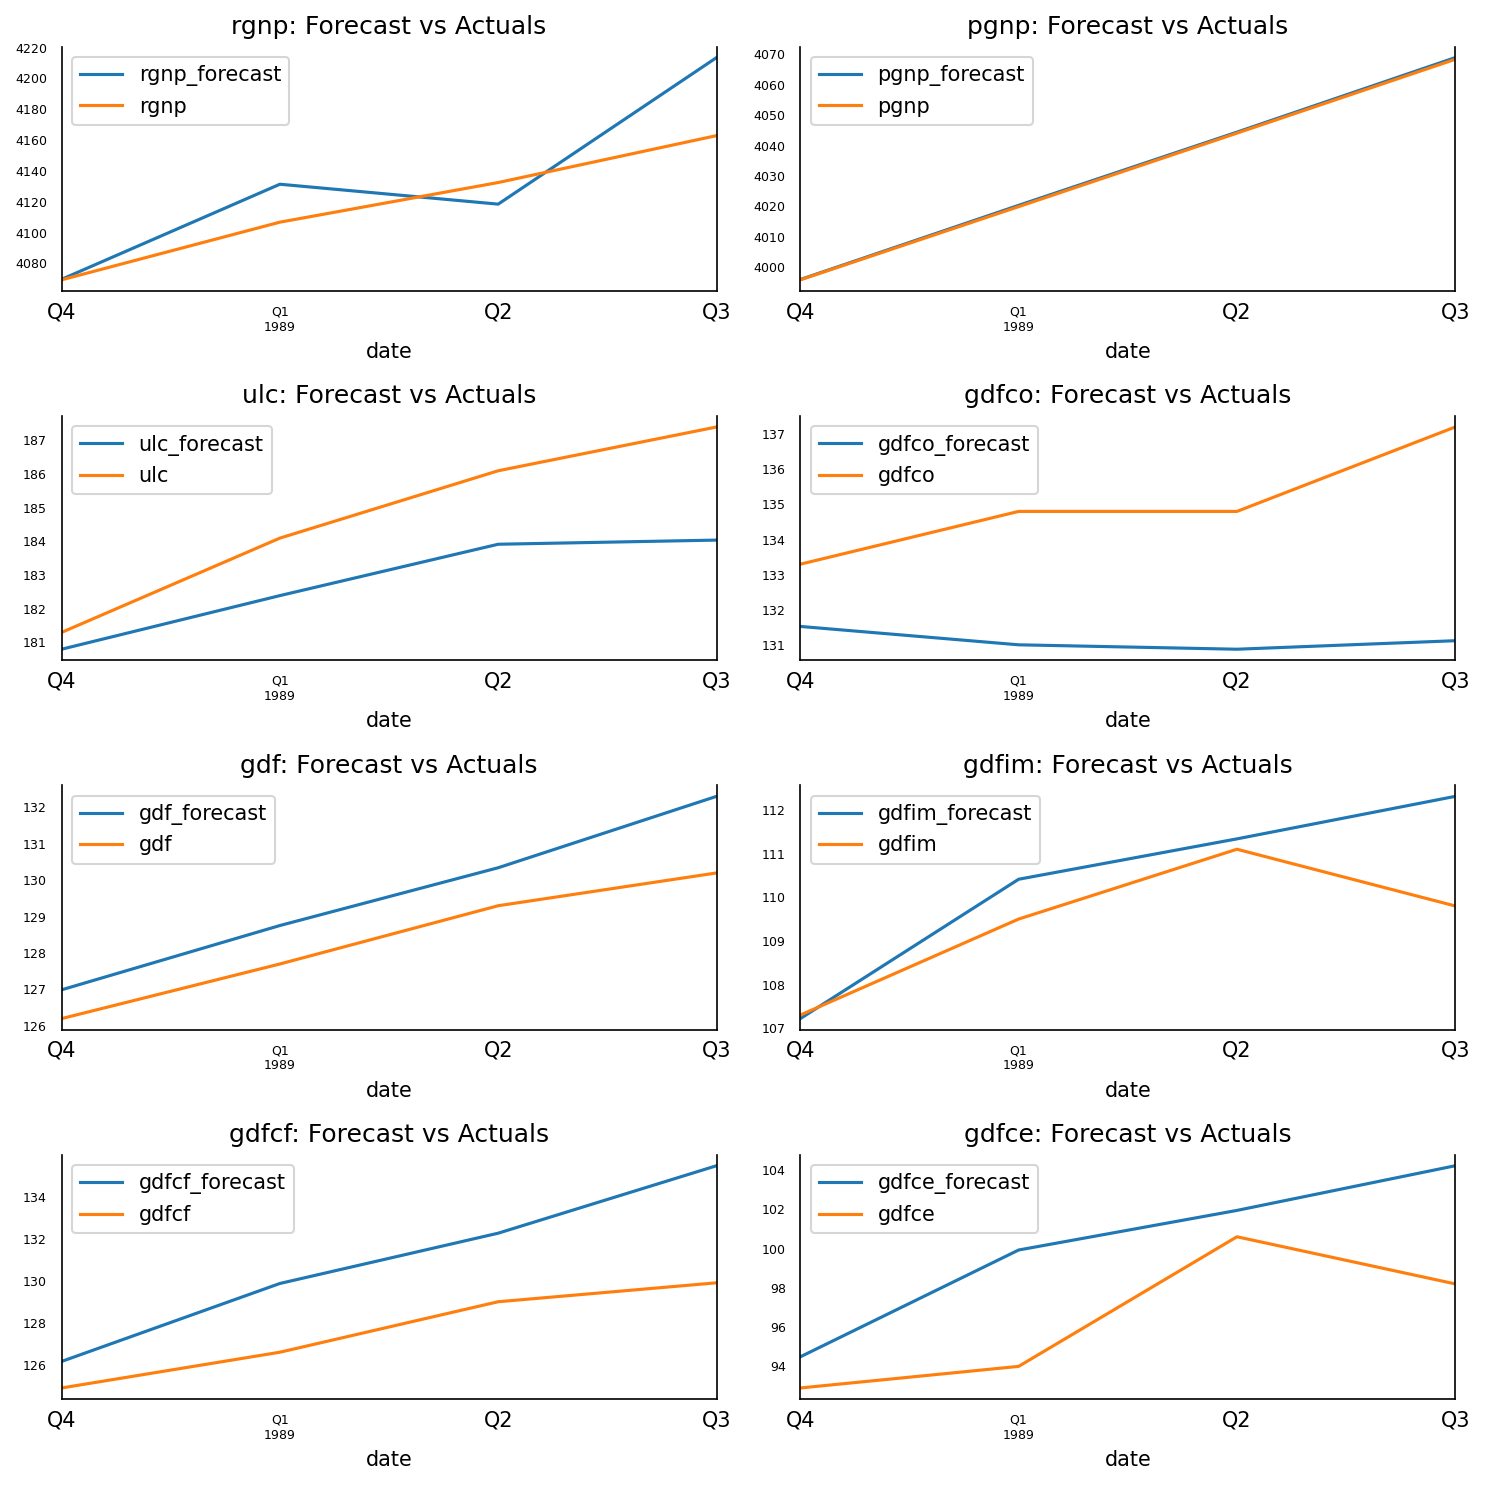

In [483]:
#Plot forecasted values vs real values

fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_df[col][-4:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [582]:
#Evaluate the Forecasts

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
   





In [583]:
forecast_accuracy(fc, test_df.values)

{'mape': 0.9986817525160281,
 'me': -1114.383770265527,
 'mae': 1114.383770265527,
 'mpe': -0.9986817525160281,
 'rmse': 2036.9832169907415,
 'corr': -0.8983204343669361,
 'minmax': 0.9986817525160281}

In [ ]:
#Forecasting by Deep Leaarning(Long Short term Memory)

#The first step is to prepare the dataset for the LSTM.This involves framing the dataset as a supervised learning problem
#and normalizing the input variables.

#We can transform the dataset using the series_to_supervised() function


In [ ]:
#Data Pre-Processing
'''In common practice, data are usually pre-processed before splitting into train and test set. Here, we will need to perform 
data transformation by normalizing each variable data using MinMaxScaler. The steps are as follows :

1. reshape each variable to 2D array with the configuration :(number of data, 1) for scaling.
2. Specify a Scaler ranging from 0 to 1 and fit each data variable individually. This step can be done by MinMaxScaler().
3. Stack all the variables horizontally.'''

In [548]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [549]:

scaler = MinMaxScaler()
scaled=scaler.fit_transform(df2.values)

In [550]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [551]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.360471,0.836364,0.672414,0.307692,0.538462,0.432836,0.611111,0.583893,0.665131,0.836364,0.275862,0.358974,0.615385,0.417910,0.500000,0.630872
2,0.665131,0.836364,0.275862,0.358974,0.615385,0.417910,0.500000,0.630872,0.628776,0.854545,0.500000,0.384615,0.384615,0.447761,0.472222,0.577181
3,0.628776,0.854545,0.500000,0.384615,0.384615,0.447761,0.472222,0.577181,0.386585,0.836364,0.500000,0.410256,0.692308,0.447761,0.666667,0.610738
4,0.386585,0.836364,0.500000,0.410256,0.692308,0.447761,0.666667,0.610738,0.588326,0.836364,0.448276,0.358974,0.461538,0.402985,0.444444,0.610738
5,0.588326,0.836364,0.448276,0.358974,0.461538,0.402985,0.444444,0.610738,0.474142,0.854545,0.431034,0.384615,0.538462,0.402985,0.583333,0.597315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.538658,0.836364,1.000000,0.512821,0.769231,0.492537,0.777778,0.751678,0.535586,0.854545,0.103448,0.282051,0.692308,0.208955,0.777778,0.583893
117,0.535586,0.854545,0.103448,0.282051,0.692308,0.208955,0.777778,0.583893,0.528418,0.836364,0.603448,0.538462,0.307692,0.582090,0.222222,0.577181
118,0.528418,0.836364,0.603448,0.538462,0.307692,0.582090,0.222222,0.577181,0.610343,0.854545,0.655172,0.307692,0.692308,0.597015,0.611111,0.671141
119,0.610343,0.854545,0.655172,0.307692,0.692308,0.597015,0.611111,0.671141,0.495648,0.836364,0.327586,0.000000,0.615385,0.343284,0.722222,0.973154


In [552]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.360471   0.836364   0.672414   0.307692   0.538462   0.432836   
2   0.665131   0.836364   0.275862   0.358974   0.615385   0.417910   
3   0.628776   0.854545   0.500000   0.384615   0.384615   0.447761   
4   0.386585   0.836364   0.500000   0.410256   0.692308   0.447761   
5   0.588326   0.836364   0.448276   0.358974   0.461538   0.402985   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.611111   0.583893  0.665131  
2   0.500000   0.630872  0.628776  
3   0.472222   0.577181  0.386585  
4   0.666667   0.610738  0.588326  
5   0.444444   0.610738  0.474142  


In [ ]:
#Define and Fit Model

'''First, we must split the prepared dataset into train and test sets. '''

In [566]:
values = reframed.values

In [567]:
test=values[:4, :]
train = values[4:, :]

In [568]:
# split into input and outputs
test_X, test_y = test[:, :-1], test[:, -1]
train_X, train_y = train[:, :-1], train[:, -1]

In [569]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(116, 1, 8) (116,) (4, 1, 8) (4,)


In [529]:
'''We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution.
The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.'''

Epoch 1/50
2/2 - 3s - loss: 0.5211 - val_loss: 0.5085 - 3s/epoch - 1s/step
Epoch 2/50
2/2 - 0s - loss: 0.4912 - val_loss: 0.4779 - 11ms/epoch - 6ms/step
Epoch 3/50
2/2 - 0s - loss: 0.4613 - val_loss: 0.4472 - 25ms/epoch - 13ms/step
Epoch 4/50
2/2 - 0s - loss: 0.4311 - val_loss: 0.4163 - 28ms/epoch - 14ms/step
Epoch 5/50
2/2 - 0s - loss: 0.4008 - val_loss: 0.3851 - 25ms/epoch - 12ms/step
Epoch 6/50
2/2 - 0s - loss: 0.3707 - val_loss: 0.3536 - 26ms/epoch - 13ms/step
Epoch 7/50
2/2 - 0s - loss: 0.3413 - val_loss: 0.3218 - 23ms/epoch - 12ms/step
Epoch 8/50
2/2 - 0s - loss: 0.3134 - val_loss: 0.2899 - 24ms/epoch - 12ms/step
Epoch 9/50
2/2 - 0s - loss: 0.2858 - val_loss: 0.2576 - 23ms/epoch - 12ms/step
Epoch 10/50
2/2 - 0s - loss: 0.2586 - val_loss: 0.2248 - 24ms/epoch - 12ms/step
Epoch 11/50
2/2 - 0s - loss: 0.2324 - val_loss: 0.1918 - 27ms/epoch - 13ms/step
Epoch 12/50
2/2 - 0s - loss: 0.2075 - val_loss: 0.1668 - 27ms/epoch - 13ms/step
Epoch 13/50
2/2 - 0s - loss: 0.1850 - val_loss: 0.1498

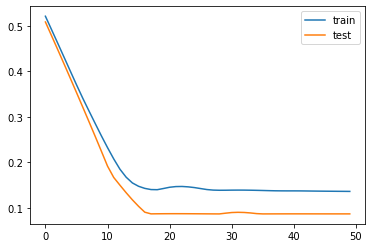

In [570]:
#Building the network

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
#Evaluate Model
'''Now we can forecast the test data using the model and the evaluate the forecated data using RMSE.'''

In [571]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [574]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [575]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 20.438
